<a href="https://colab.research.google.com/github/MasoudMoeini/image-blur-classification/blob/main/resnet_blur_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.optimizers import gradient_descent_v2 
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [2]:
!unzip -qq classification.zip

In [3]:
!ls classification

no_blur  test  train


In [ ]:
#!unzip -qq train.zip
#!ls train

In [ ]:
!ls train

blur  real


In [ ]:
#train_path = "train"
#val_path = "test"
#class_names = ['blur','real']
#class_names_val = ['blur','real']

In [16]:
image_size = (244, 244)
batch_size = 50

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "classification/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "classification/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3600 files belonging to 2 classes.
Using 2880 files for training.
Found 3600 files belonging to 2 classes.
Using 720 files for validation.


 blurry images class: 0 , real sharp images calss: 1


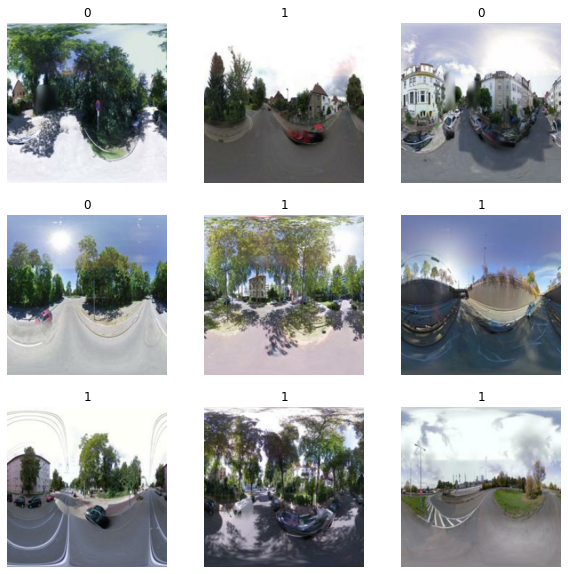

In [5]:
import matplotlib.pyplot as plt
print(' blurry images class: 0 , real sharp images calss: 1')
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

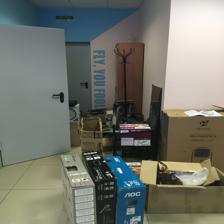

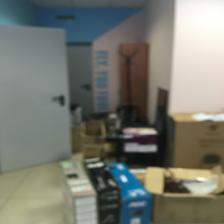

In [ ]:
#Sample datasets images
image_real=cv2.imread("train/real/0_IPHONE-SE.jpg")
cv2_imshow(image_real)
image_blur=cv2.imread("train/blur/0_IPHONE-SE.jpg")
cv2_imshow(image_blur)

**Using image data augmentation**

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

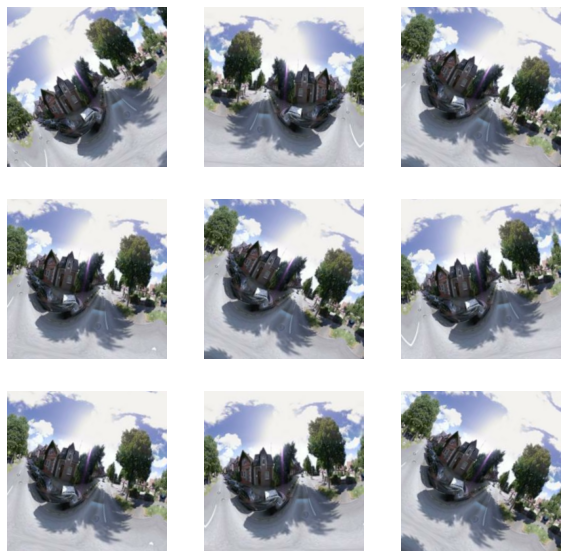

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
#inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
#x = layers.Rescaling(1./255)(x)

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
#train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
#test_datagen = ImageDataGenerator()

In [ ]:
#train_generator = train_datagen.flow_from_directory("train",target_size=(224, 224),batch_size=10,shuffle=False,class_mode='binary')
#test_generator = test_datagen.flow_from_directory("test",target_size=(224,224),batch_size=10,shuffle=False,class_mode='binary')

In [10]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [11]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [12]:
def ResNet50(input_shape):
    X_input = keras.Input(shape=input_shape)
    #X = data_augmentation(X_input)
    #X = layers.Rescaling(1./255)(X)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [13]:
def make_model(input_shape,num_classes):
    model = ResNet50(input_shape)
    return model

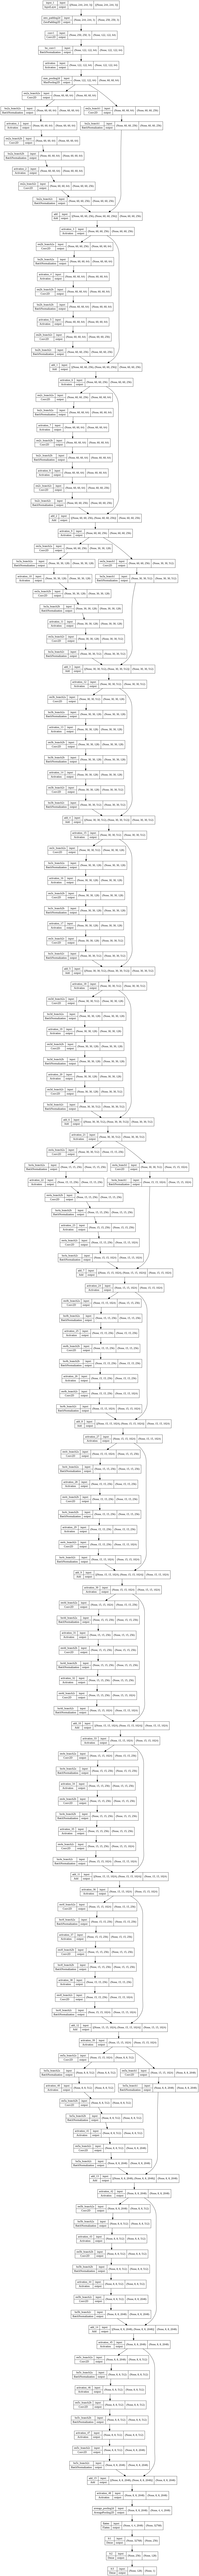

In [14]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [17]:
epochs = 50
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds,shuffle=True)
model.save('image_blur_classifier.h5')

Epoch 1/50
58/58 [==============================] - 89s 1s/step - loss: 0.6425 - binary_accuracy: 0.6347 - val_loss: 780.4756 - val_binary_accuracy: 0.4944
Epoch 2/50
58/58 [==============================] - 75s 1s/step - loss: 0.6069 - binary_accuracy: 0.6760 - val_loss: 45.5476 - val_binary_accuracy: 0.4944
Epoch 3/50
58/58 [==============================] - 75s 1s/step - loss: 0.5869 - binary_accuracy: 0.6854 - val_loss: 4.9328 - val_binary_accuracy: 0.5069
Epoch 4/50
58/58 [==============================] - 75s 1s/step - loss: 0.5896 - binary_accuracy: 0.6795 - val_loss: 1.2545 - val_binary_accuracy: 0.5847
Epoch 5/50
58/58 [==============================] - 75s 1s/step - loss: 0.5114 - binary_accuracy: 0.7437 - val_loss: 2.8983 - val_binary_accuracy: 0.5014
Epoch 6/50
58/58 [==============================] - 75s 1s/step - loss: 0.5064 - binary_accuracy: 0.7375 - val_loss: 10.5696 - val_binary_accuracy: 0.4944
Epoch 7/50
58/58 [==============================] - 75s 1s/step - loss: 

In [18]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


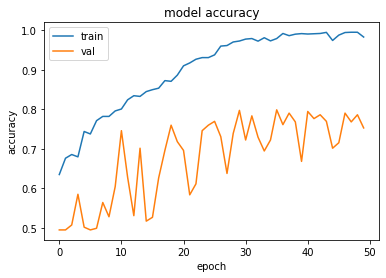

In [19]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

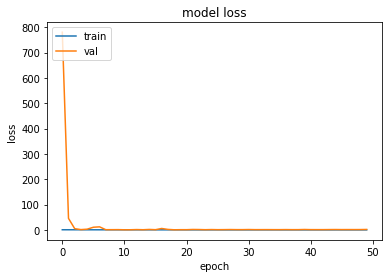

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:

test_images = np.load('real.npy')

In [ ]:
test_images.shape

(350, 224, 224, 3)

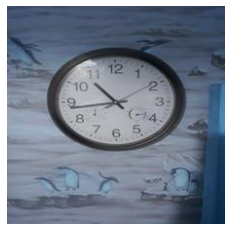

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
image = Image.fromarray(test_images[10],'RGB')
plt.imshow(image)
plt.axis("off")
image.show()

In [ ]:
!unzip -qq test.zip

This image is 100.00 percent BLURRY IMAGE  and 0.00 percent Real SHARP IMAGE.


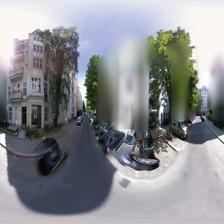

In [22]:
path = "classification/test/110.jpg"
img = keras.preprocessing.image.load_img(path, target_size = image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent BLURRY IMAGE  and %.2f percent Real SHARP IMAGE."
    % (100 * (1 - score), 100 * score)
)
image=cv2.imread(path)
cv2_imshow(image)

This image is 0.00 percent BLURRY IMAGE  and 100.00 percent Real SHARP IMAGE.


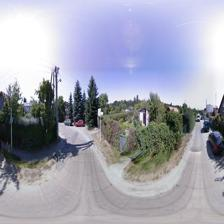

In [23]:
path = "classification/test/140.jpg"
img = keras.preprocessing.image.load_img(path
    , target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent BLURRY IMAGE  and %.2f percent Real SHARP IMAGE."
    % (100 * (1 - score), 100 * score)
)
image=cv2.imread(path)
cv2_imshow(image)

In [ ]:

#model.compile(loss='categorical_crossentropy', optimizer='adam')
#es= EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=20)
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode="auto")
#H = model.fit(train_generator,validation_data=test_generator,epochs=3,verbose=1,callbacks=[mc,es])